# Geosilhouettes: geographical measures of cluster fit

[Silhouette statistics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) ([Rousseeuw, 1987](https://doi.org/10.1016/0377-0427(87)90125-7)) are a nonparametric measure of an observation's goodness of fit to a given cluster. Where clusters have a *geographical* interpretation, such as when they represent geographical regions, silhouette statistics can incorporate *spatial thinking* in order to provide more useful measures of cluster fit.   The [paper by Wolf, Knaap, & Rey (2019)](https://doi.org/10.1177%2F2399808319875752).
([preprint on SocArXiv](https://osf.io/preprints/socarxiv/vd3uk/)) defines two:

1. **Path Silhouettes**, which characterize the joint geographical and feature similarity in a clustering.
2. **Boundary Silhouettes**, which characterize how well-defined a geographical boundary is in a clustering. 

Together, these two new measures provide new ways to measure the goodness of fit of clusters in clustering problems in geographic data science. 

Below, we'll dig a little into how these are implemented in the `esda` package. First, though, let's set up some data. We'll be considering a single *univariate* dataset, the Gini index in 1989 in counties for the US Deep South.

In [1]:
import libpysal
import numpy
import esda
import geopandas
import contextily
import matplotlib.pyplot as plt
%matplotlib inline

To focus in on only the deep south, we'll build an array of states that fall within the deep south:

In [2]:
focus_states = ["Alabama", "Georgia", "Louisiana", 
                "Mississippi", "South Carolina"]

Then, we'll read in data for all of the south, using the example datasets in the `libpysal` package:

In [3]:
south = geopandas.read_file(libpysal.examples.get_path('south.shp'))

Then, we'll filter out only the states in the deep south:

In [4]:
deep = south.query('STATE_NAME in @focus_states').reset_index()

In [5]:
deep['state_label'] = deep.STATE_NAME.apply(lambda x: focus_states.index(x))

Finally, for mapping purposes, let's get a basemap. This is done using the `contextily` package, which expects our data in a specific coordinate projection system. For more, check out the [`contextily` user guide](https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb). 

In [6]:
deep.crs = {'init':'epsg:4326'}

In [7]:
deep = deep.to_crs(epsg=3857)

In [11]:
basemap, extent = contextily.bounds2img(*deep.total_bounds, zoom=6,
                                        url=contextily.tile_providers.ST_TONER_LITE)

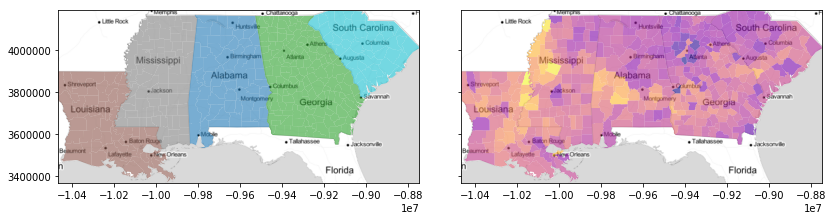

In [18]:
f,ax = plt.subplots(1,2, figsize=(12,3), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], alpha=.6)
deep.plot('GI89', ax=ax[1], cmap='plasma', alpha=.6)
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')
    ax_.axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

# The Silhouette Score

The standard silhouette score used in classification/grouping problems as measure of how well-fit an observation is to its current group. The measure is fairly robust, well-studied, and is common in many different problem areas. 

Statistically, the silhouette score is composed of a few components: 
- $c$, the cluster in which $i$ is assigned
- $k$, another cluster in which $i$ is not currently assigned
- $d_i(c)$: the dissimilarity between observation $i$ and $i$'s own cluster $c$
- $d_i(k)$: the dissimilarity between observation $i$ and a cluster $k$ that $i$ is not in. 

Here, we define $d$ as an arbitrary dissimilarity metric. For most cases, it's normally the euclidean distance. So, if you see $d_i(c)$, this is the average dissimilarity between observation $i$ and all other observations $j$ in cluster $c$. 

Then, we need to define the *second best choice cluster*, $\hat{k}$, which is a cluster that $i$ is most similar to, but of which $i$ is not currently a member:
$$\hat{k}_i = k\ | \min_k \{d_i(k)\}$$

This lets us define the silhouette score as the relationship between the dissimilarity scores for $i$ and its cluster $c$, and $i$ and the second-best choice cluster, $\hat{k}$:
$$ s_i = \frac{d_i(c) - d_i(\hat{k})}{\max\left\{d_i(c), d_i(\hat{k})\right\}}$$

This value is close to 1 when $i$ is much closer to its current cluster, $c$, than the second-best cluster, $\hat{k}$, indicating strong fit to its current cluster. And, when $i$ is more similar to $\hat{k}$ than to its own cluster $c$, the value of $s_i$ is close to -1. We can compute the score for each observation using `sklearn`'s `silhouette_samples`:

In [21]:
from sklearn.metrics import silhouette_samples
silhouettes = silhouette_samples(deep[['GI89']].values, deep.state_label)

Here, we can visualize the silhouette scores by county. With this information, we can see that there is very strong heterogeneity in the Gini coefficient *within* states, because the silhouette statisic for each county is usually negative (i.e. blue). But, in some areas (e.g. areas of South Carolina and Louisiana), the silhouette statistics for counties are positive (red), suggesting those counties are well-fit to their surroundings. 

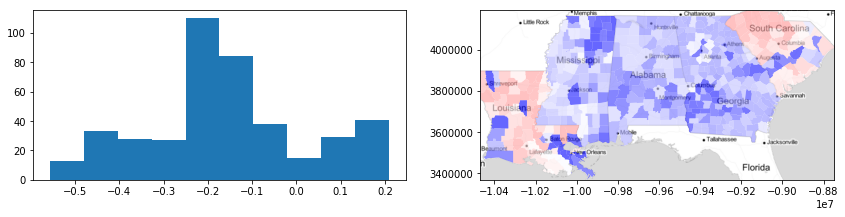

In [27]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(silhouettes)
deep.plot(silhouettes, ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, alpha=.6)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

On the contrary, if we used a *data-driven* definition of regions, we might expect the silhouette scores to be more positive. For example, if we used $k$-means to define the *best* data-driven groups we could have for this data, we might have something like this:

In [29]:
from sklearn.cluster import KMeans
data_driven_clustering = KMeans(n_clusters=len(focus_states)).fit(deep[['GI89']].values)
data_labels = data_driven_clustering.labels_
data_silhouettes = silhouette_samples(deep[['GI89']].values, 
                                      data_labels)

This yields the following geography of inequality in the deep south:

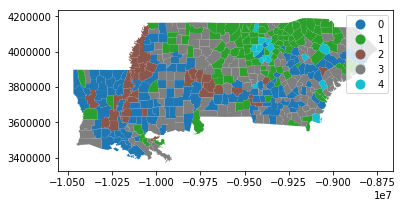

In [33]:
deep.plot(data_labels, categorical=True, legend=True)
plt.show()

And, in this geography of inequality, each county is very well fit to its group:

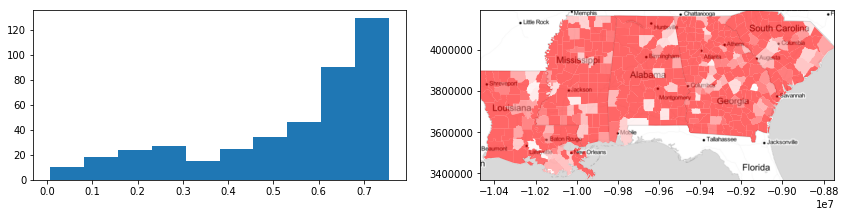

In [30]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(data_silhouettes)
deep.plot(data_silhouettes, ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, alpha=.6)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

# Nearest Label

Fundamental to the measurement of the silhouette score is the idea of a *next best fit cluster*. This is $\hat{k}_i$, the cluster to which $i$ *would* be assigned if it were not in its current cluster, $c$. This is a useful concept, because it shows the latent relationship between observations and other clusters. It gets at how the clustering *might* be different if different decisions about grouping/classification had been made, and helps us construct a measure of how much "better" $c$ currently is for $i$ than $\hat{k}_i$ would be. 

But, by default, `scikit-learn` does not provide you with $\hat{k}_i$. Instead, it only provides $s_i$. So, `esda` provides this for you in the `nearest_label` function:

In [37]:
nearest_label = esda.nearest_label(deep[['GI89']].values, deep.state_label)

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


With this function, you can visualize the geography of the *second-best choice*, $\hat{k}_i$. For example, most of the south of Alabama and Georgia and the [Mississippi Delta region](https://en.wikipedia.org/wiki/Mississippi_Delta) has a "second choice" similarity to the inequality profile of Louisiana. This means that, if these counties *were not* in their own states, they'd be most similar to counies in Louisiana. 

However, keep in mind that this idea of a *second choice* excludes $c_i$ from the potential list of *nearest labels*!

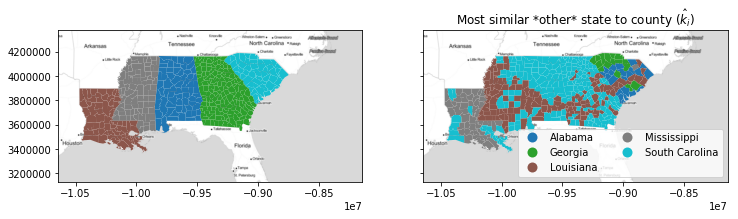

In [54]:
nearest_outside_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_outside_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

To allow for this, the `keep_self` argument modifies `nearest_label` to return the nearest label out of *any* group, regardless of whether or not the observation is currently in that group. This means that the *nearest alternative label* is provided by `nearest_label`, but the *absolute nearest label* is provided by `nearest_label(data, labels, keep_self=True)`. 

These two can be quite different. Below, you can see that the similarities definitely shift when we allow observations' nearest labels to be their *current* classification. There, we see that most counties are either more similar to Louisiana, or they're more similar to South Carolina. Forcing the return of the *nearest alternative label* caused Mississippi to be included as the second choice of most of the counties in Louisiana, and for Alabama & Georgia to be given the second choice of many counties in South Carolina. 

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


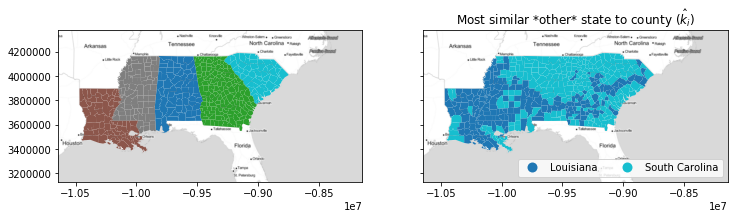

In [62]:
nearest_label = esda.nearest_label(deep[['GI89']].values, 
                                   deep.state_label, keep_self=True)
nearest_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

# Geographical Structure

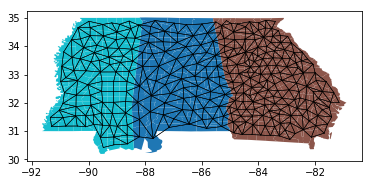

In [16]:
w = libpysal.weights.Rook.from_dataframe(df)
f,ax = w.plot(df, edge_kws=dict(linewidth=.5), 
              node_kws=dict(s=0))
df.plot('STATE_NAME', ax=ax)

# Path Silhouettes

In [20]:
path_silhouette = esda.path_silhouette(df[['GI89']].values, df.label, w)

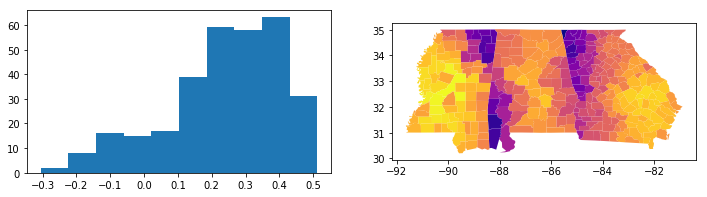

In [22]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(path_silhouette)
df.plot(path_silhouette, ax=ax[1], cmap='plasma')

# Boundary Silhouettes

In [36]:
boundary_silhouette = esda.boundary_silhouette(df[['GI89']].values, df.label, w)

In [37]:
df['boundary_silhouette'] = boundary_silhouette

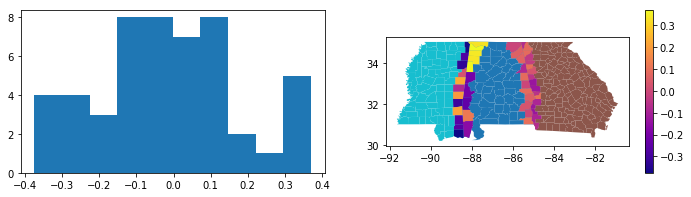

In [40]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(df.query('boundary_silhouette != 0').boundary_silhouette)
df.plot('STATE_NAME', ax=ax[1])
df.query('boundary_silhouette != 0')\
  .plot('boundary_silhouette', ax=ax[1], cmap='plasma', legend=True)